In [1]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
starts = [[4, 199, 2, 3], [6, 149, 6, 0], [2, 99,3]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=1, start_indices=starts)
# f2 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=2, start_indices=starts) 
# f3 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=3, start_indices=starts) 
# f4 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=4, start_indices=starts)

x, data1, ir_avgs, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
# x, data2, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f2, kind='adj')
# x, data3, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f3, kind='adj')
# x, data4, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f4, kind='adj')

# x0, data0, frequencies0, gases0, sizes0 = hdf5_io.unpack_data(f, kind='adj')

colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

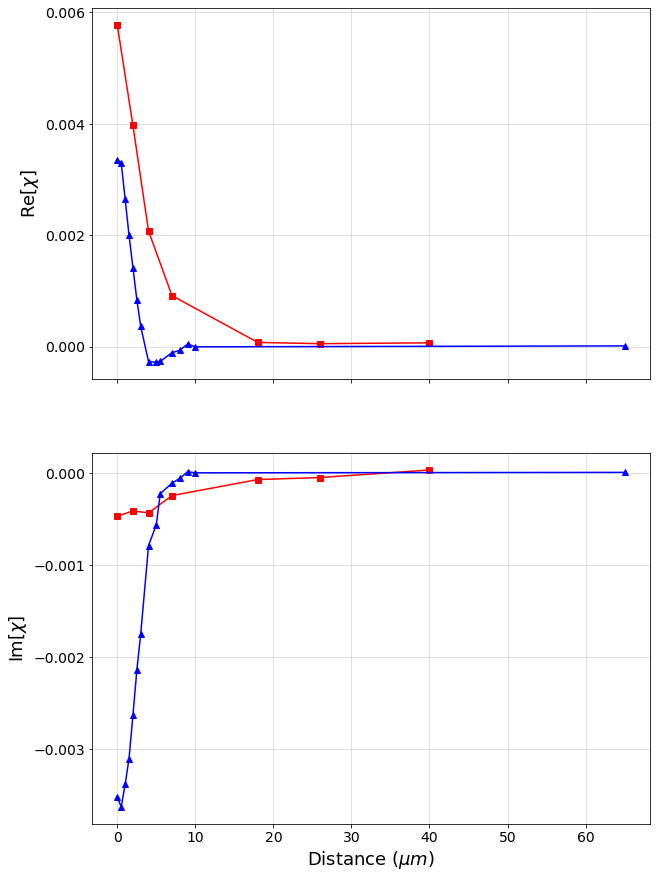

In [3]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

# for iy in np.arange(1,sizes[0]):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
# fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')
# for ax in axes:
#     ax.set_xlim(460,480)

In [4]:
dc_data = [data1[0], data1[4], data1[8]]
dc_x = [x[0], x[4], x[8]]

In [5]:
def chi_dc(x, amp=1, ld=10, base=0):
    chi = amp * (np.exp(-x / ld)) + base
    return chi

In [6]:
dc_data_dum = [data/np.max(data) for data in dc_data]

In [7]:
chi_dc(0, amp=-.0610703, ld=29.08717, base=0)

-0.0610703

In [8]:
chi_dc(0, amp=-.0610703, ld=29.08717, base=2.76867e-3)

-0.05830163

In [9]:
dc_params = Parameters()

for iy, (data, dum_x) in enumerate(zip(dc_data, dc_x)):
    base_inds =  dum_x > .7 * dum_x[-1]
    est_base = np.mean(data[base_inds]).real
    
    dc_params.add(f'amp_{iy+1}', value=data[0].real - est_base, min=-1, max=1, vary=True)
#     dc_params.add(f'amp_{iy+1}', value=data[0].real, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=-1, vary=False)
#     dc_params[f'amp_{iy+1}'].expr = f'amp_{iy+1} - base_{iy+1}'

    dc_params.add(f'ld_{iy+1}', value=30/(iy+1), min=1e-9, max=100)
    
#     dc_params.add(f'base_{iy+1}', value=est_base, min=-1, max=11)
    dc_params.add(f'base_{iy+1}', value=1e-9, min=-1, max=11)

dc_mini = lmfit.Minimizer(models.objective_fun, dc_params, fcn_args=(dc_x, dc_data, chi_dc))

dc_out = dc_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\20201211_processed_DC_data_FixAmpNeg.txt', dc_out, starts)
print('\u03A7_red = ', dc_out.redchi)
print(fit_report(dc_out))

Χ_red =  1.8855268895857036e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 744
    # variables        = 9
    chi-square         = 0.00138586
    reduced chi-square = 1.8855e-06
    Akaike info crit   = -9797.94450
    Bayesian info crit = -9756.43613
[[Variables]]
    amp_1:   0.05188052 +/- 4.7064e-04 (0.91%) (init = 0.05332507)
    ld_1:    33.7274363 +/- 0.61852476 (1.83%) (init = 30)
    base_1:  0.00276142 +/- 1.6345e-04 (5.92%) (init = 1e-09)
    amp_2:   0.03957329 +/- 6.2607e-04 (1.58%) (init = 0.04008441)
    ld_2:    17.3600564 +/- 0.48732082 (2.81%) (init = 15)
    base_2:  0.00139985 +/- 1.7378e-04 (12.41%) (init = 1e-09)
    amp_3:   0.02644602 +/- 0.00104411 (3.95%) (init = 0.02444984)
    ld_3:    4.66520884 +/- 0.31617108 (6.78%) (init = 10)
    base_3: -4.8612e-05 +/- 2.0189e-04 (415.31%) (init = 1e-09)
[[Correlations]] (unreported correlations are < 0.100)
    C(ld_1, base_1) = -0.648
    C(ld_2, base_2) =

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


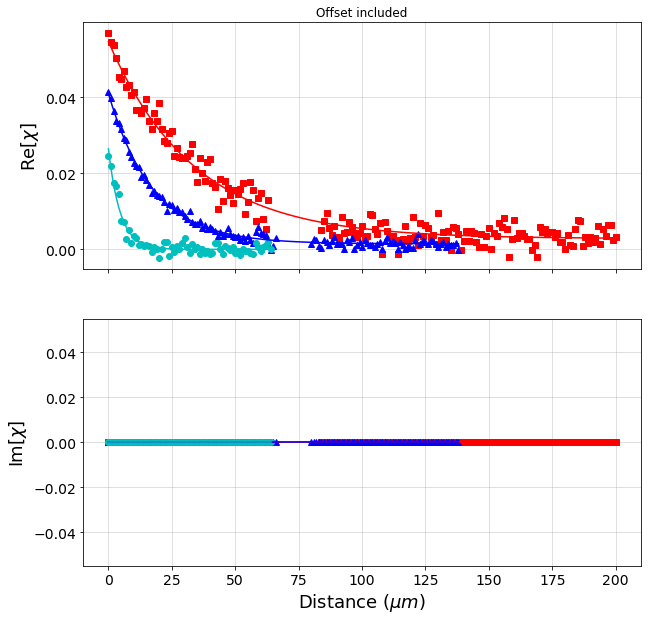

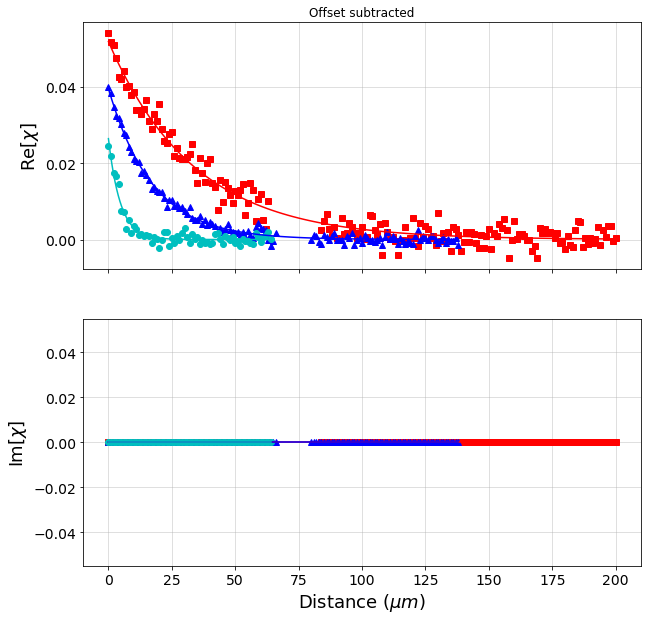

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, iy, y, chi_dc),
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset included')
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy] - dc_out.params[f'base_{iy+1}'], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, iy, y, chi_dc) - dc_out.params[f'base_{iy+1}'],
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset subtracted')
plt.show()

In [11]:
import itertools
ac_data = []
ac_data.append(data1[1:4])
ac_data.append(data1[5:8])
ac_data.append(data1[9:])
ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append(x[1:4])
ac_x.append(x[5:8])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 1, 4, 0.25, 1, 5, 0.5, 8]

In [17]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
#     est_amp = -np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy])))
#     ac_params.add(f'amp_{iy+1}', value=-data[0].real, min=-1, max=-1e-3)
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=.2)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

## params pinned to F1
# ac_params[f'amp_2'].expr = 'amp_1'
# ac_params[f'amp_3'].expr = 'amp_1'
# ac_params[f'amp_5'].expr = 'amp_4'
# ac_params[f'amp_6'].expr = 'amp_4'
# ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

ac_params.add(f'gammap_7', value=0.1041, vary=False)
ac_params.add(f'gammap_8', value=0.1041, vary=False)
# ac_params.add(f'gammap_7', value=0, vary=False)
# ac_params.add(f'gammap_8', value=0, vary=False)
ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned.txt', ac_out, starts)
print('\u03A7_red = ', ac_out.redchi)
print(fit_report(ac_out))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
Χ_red =  2.5447082276885063e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 113
    # data points      = 260
    # variables        = 13
    chi-square         = 6.2854e-05
    reduced chi-square = 2.5447e-07
    Akaike info crit   = -3935.

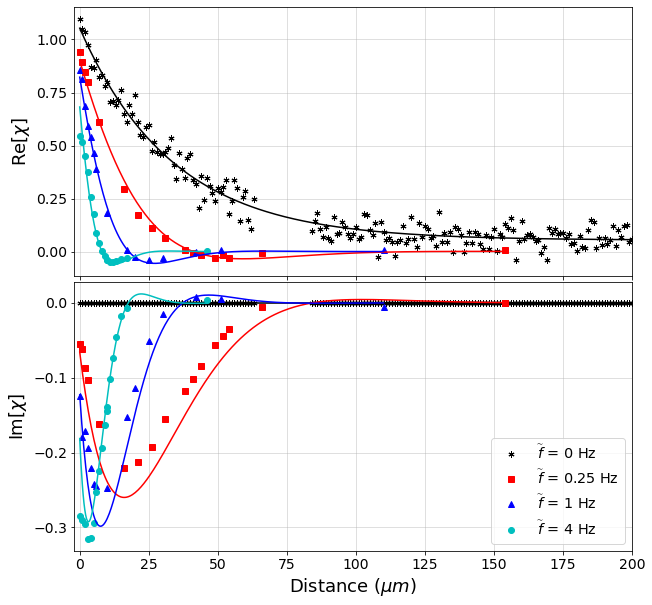

In [20]:
# 1% O2 Plots
# DC scaling
DC_ind = 0
ac_start = 0
ac_end = 3

# norm = ac_out.params[f'amp_1'] / dc_out.params[f'amp_1']
DC_norm = 1 / dc_out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], dc_data[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, dc_x[DC_ind][-1], num=300)
visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) * DC_norm,
                       color=colors[0], marker='')

for iy in np.arange(ac_start, ac_end):
    f_norm =  -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label='$\widetilde{f}$ = ' + str(ac_freqs[iy]) + ' Hz')
for iy in np.arange(ac_start, ac_end):
    f_norm = -1/ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[1].set_xlabel('y $(\mu m)$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
for ax in axes:
    ax.set_xlim(-2, 200)
plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

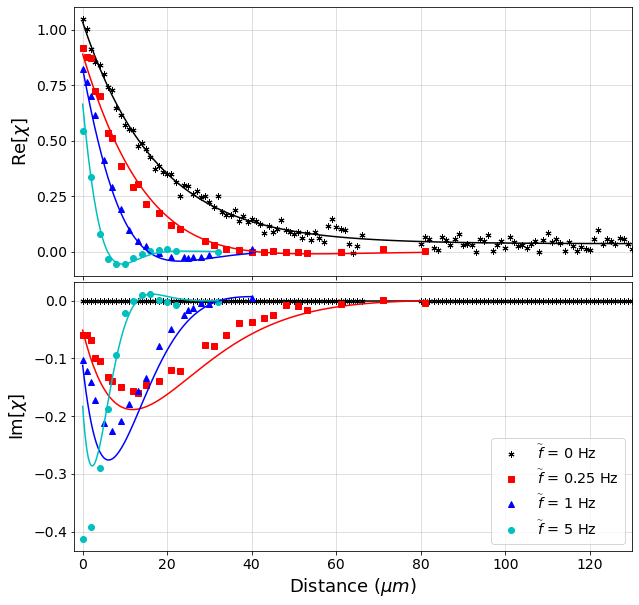

In [21]:
# 10% O2 Plots
# DC scaling
DC_ind = 1
ac_start = 3
ac_end = 6

# norm = ac_out.params[f'amp_1'] / dc_out.params[f'amp_1']
DC_norm = 1 / dc_out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], dc_data[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, dc_x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) * DC_norm,
                       color=colors[0], marker='')

for iy in np.arange(ac_start, ac_end):
    f_norm =  -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=colors[iy+1 - ac_start],
                           marker=markers[iy+1- ac_start], ls='',
                           label='$\widetilde{f}$ = ' + str(ac_freqs[iy]) + ' Hz')
for iy in np.arange(ac_start, ac_end):
    f_norm = -1/ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=200)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy+1- ac_start], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[1].set_xlabel('y $(\mu m)$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
for ax in axes:
    ax.set_xlim(-2, 130)
plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

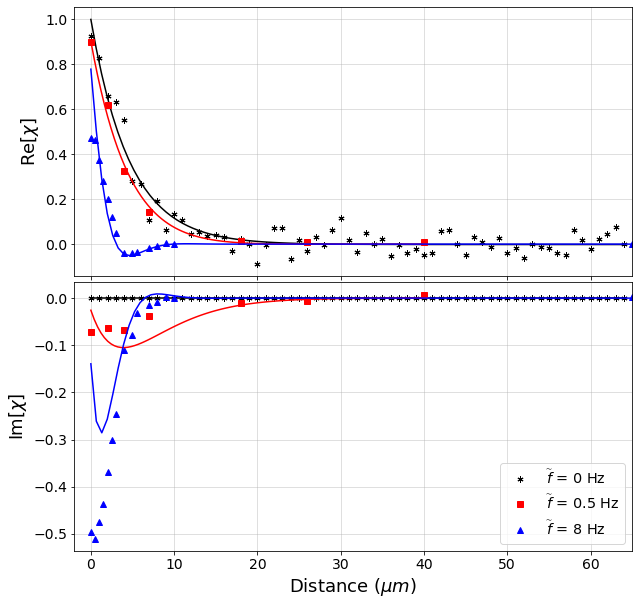

In [22]:
# 100% O2 Plots
# DC scaling
DC_ind = 2
ac_start = 6
ac_end = 8

# norm = ac_out.params[f'amp_1'] / dc_out.params[f'amp_1']
DC_norm = 1/ dc_out.params[f'amp_{DC_ind+1}']

fig, axes = plt.subplots(nrows=2, figsize=(10,10))
# Plotting steady-state data, scaled down by a normalization factor
visualization.plot_chi(axes, dc_x[DC_ind], dc_data[DC_ind] * DC_norm, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, dc_x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, models.dataset_fun(dc_out.params, DC_ind, y, chi_dc) * DC_norm,
                       color=colors[0], marker='')

for iy in np.arange(ac_start, ac_end):
    f_norm = -1/ac_out.params[f'amp_{iy+1}']
    visualization.plot_chi(axes, ac_x[iy], ac_data[iy] * f_norm, color=colors[iy+1 - ac_start],
                           marker=markers[iy+1- ac_start], ls='',
                           label='$\widetilde{f}$ = ' + str(ac_freqs[iy]) + ' Hz')
for iy in np.arange(ac_start, ac_end):
    f_norm = -1/ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=colors[iy+1- ac_start], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[1].set_xlabel('y $(\mu m)$')
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
for ax in axes:
    ax.set_xlim(-2, 65)
plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

## Plotting highest freq line parametric in po2

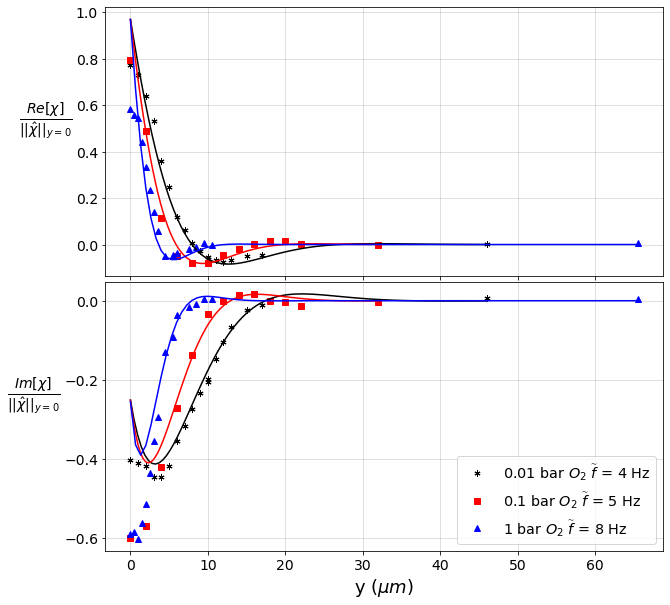

In [34]:

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi(axes, x[iy], data1[iy]/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]} bar $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.dataset_fun(out.params, iy, y, chi_pattern)/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_ylabel('Re[$\chi$] / ||$\hat{\chi}||_{y=0}$')
# axes[1].set_ylabel('Im[$\chi$] / ||$\hat{\chi}||_{y=0}$')
axes[0].set_ylabel(r'$\frac{Re[\chi]}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
axes[1].set_ylabel(r'$\frac{Im[\chi]}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
axes[1].set_xlabel('y $(\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_high_f_parametric_pO2.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line parametric in po2

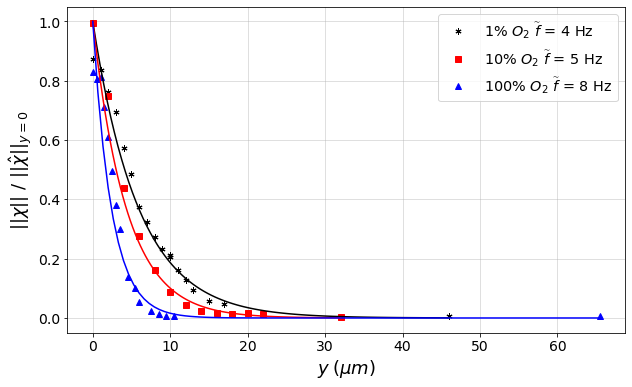

In [82]:
fig, ax = plt.subplots(figsize=(10,6))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy], np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y, np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \: (\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_y_parametric_f.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line vs y*sqrt(f) parametric in po2

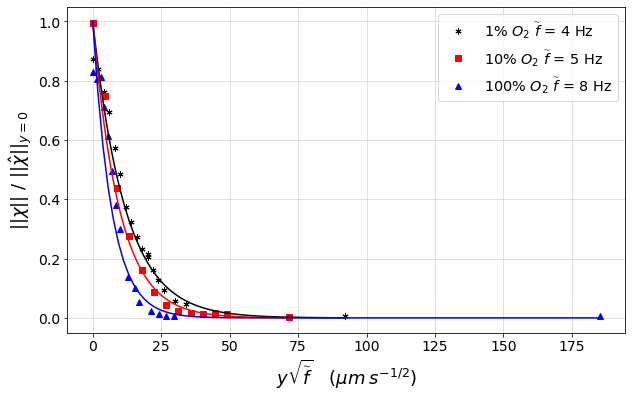

In [84]:
fig, ax = plt.subplots(figsize=(10,6))

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy]*np.sqrt(frequencies[iy]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y*np.sqrt(frequencies[iy]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y\sqrt{\widetilde{f}} \quad (\mu m \: s^{-1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_yf_parametric_f.png', dpi=400, bbox_inches='tight')

## Plotting Magnitude of highest freq line vs y*sqrt(f) parametric in po2

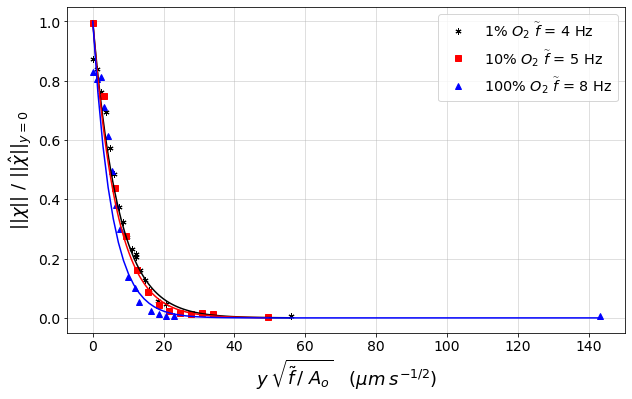

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
Aos = [2.689, 2.088, 1.673]

for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi_mag(ax, x[iy]*np.sqrt(frequencies[iy]/Aos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y*np.sqrt(frequencies[iy]/Aos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
# ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y\, \sqrt{\tilde{f}\, / \,{ \, A_o}} \quad (\mu m \: s^{-1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_vs_yfAo_parametric_f.png', dpi=400, bbox_inches='tight')

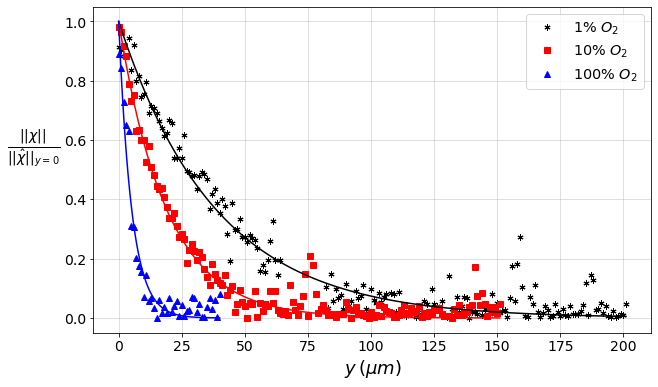

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
Aos = [2.689, 2.088, 1.673]

for j, iy in enumerate([0, 4, 8]):
    visualization.plot_chi_mag(ax, x[iy], np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ')
for j, iy in enumerate([0, 4, 8]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y, np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
# ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y \, (\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_f0_vs_y_parametric_pO2.png', dpi=400, bbox_inches='tight')

## Steady state vs y

0 1.68e-06 0.02008
1 1.464e-06 0.0131
2 1.095e-06 0.007533


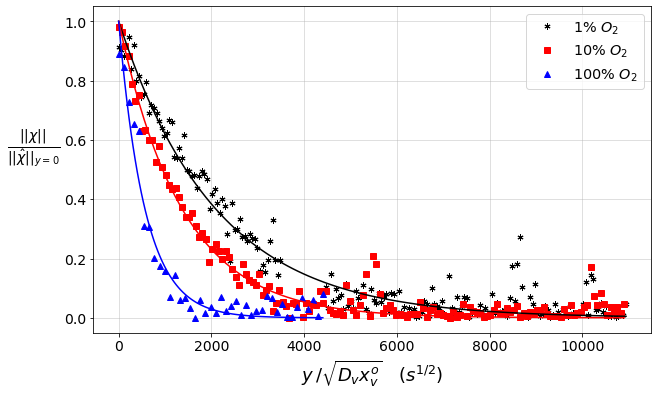

In [102]:
fig, ax = plt.subplots(figsize=(10,6))
Dvs = [1.68e-6, 1.464e-6, 1.095e-6]
xvos = [0.02008, 0.01310, 0.007533]

for j, iy in enumerate([0, 4, 8]):
    print(j, Dvs[j], xvos[j])
    visualization.plot_chi_mag(ax, x[iy]/np.sqrt(Dvs[j]*1e4*xvos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ')
for j, iy in enumerate([0, 4, 8]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi_mag(ax, y/np.sqrt(Dvs[j]*1e4*xvos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
ax.set_ylabel(r'$\frac{||\chi||}{||\hat{\chi}||_{y=0}}$', rotation=0, labelpad=30, fontsize=20)
# ax.set_ylabel('||$\chi$|| / ||$\hat{\chi}||_{y=0}$')
ax.set_xlabel(r'$y\, / \sqrt{D_v x^o_v} \quad (s^{1/2})$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_Xmag_f0_vs_yDvxv_parametric_pO2.png', dpi=400, bbox_inches='tight')

In [101]:
for j, iy in enumerate([0, 4, 8]):
    tg = out.params[f'tg_{iy+1}'].value
    ld = out.params[f'ld_{iy+1}'].value *1e-4
    xvo = xvos[j]
    Ao = Aos[j]
    print(f'Ao: {Ao} tg: {tg} ld: {ld*1e4} xvo: {xvo}')
    print(f'Dv: {calc_Dv(Ao, tg, ld)} Roo: {calc_Roo(Ao, tg, xvo, 630e-7)} \n')

Ao: 2.689 tg: 3.261103510552789 ld: 38.37923860323772 xvo: 0.02008
Dv: 1.6797216622792594e-06 Roo: 3.0126338868201956e-09 

Ao: 2.088 tg: 1.169715942358389 ld: 18.913225277517647 xvo: 0.0131
Dv: 1.4646042419251228e-06 Roo: 7.056647550213476e-09 

Ao: 1.673 tg: 0.15867040451173617 ld: 5.136780215429462 xvo: 0.007533
Dv: 9.940085008142314e-07 Roo: 3.733482603873752e-08 



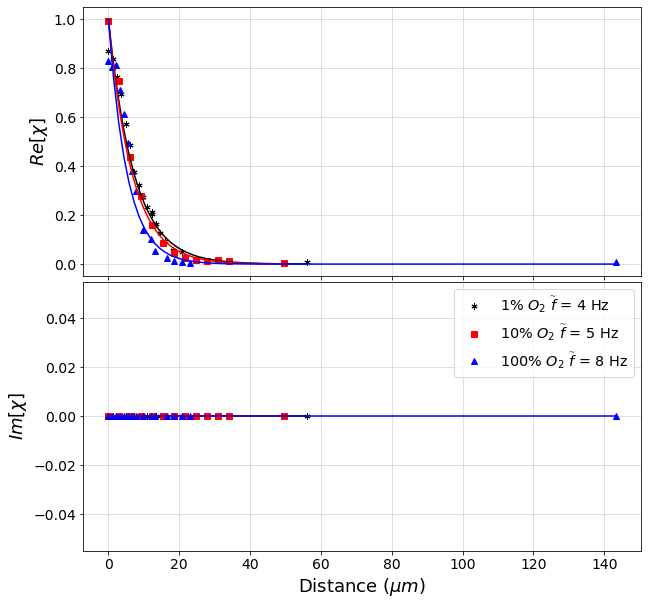

In [20]:
# Plotting highest freq line parametric in po2
fig, axes = plt.subplots(nrows=2, figsize=(10,10))
Aos = [2.689, 2.088, 1.673]
for j, iy in enumerate([3, 7, 10]):
    visualization.plot_chi(axes, x[iy]*np.sqrt(frequencies[iy]/Aos[j]), np.abs(data1[iy])/np.abs(models.dataset_fun(out.params, iy, 0, chi_pattern)), color=colors[j],
                           marker=markers[j], ls='',
                           label=f'{gases[iy]*100:.0f}% $O_2$ ' + '$\widetilde{f}$ = ' + f'{frequencies[iy]} Hz')
for j, iy in enumerate([3, 7, 10]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y*np.sqrt(frequencies[iy]/Aos[j]), np.abs(models.dataset_fun(out.params, iy, y, chi_pattern)/models.dataset_fun(out.params, iy, 0, chi_pattern)),
                           color=colors[j], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Pattern_Amp_Model_1%O2_parametric_f.png', dpi=400, bbox_inches='tight')

In [8]:
# Including surface diffusion model

In [9]:
def chi_surf_diff(x, amp=1, gammap=1e-3, ld=15, tg=1, nu=1e-3, f=1, L=0.6):

    g_p = gammap
    w = 2 * np.pi * f
    numer = -amp * np.sqrt(1+ 2 * nu) * np.exp(-(x/ ld)*np.sqrt(1 + 1j * tg * w)/np.sqrt(1 + 2 * nu))
    denom = (np.sqrt(1 + 2 * nu) + g_p * np.sqrt(1 + 1j * tg * w) * (1 - 2 * nu))
#     chi = - amp * np.sqrt(1+2*nu)*np.exp(-(x+yd)/ld*(np.sqrt(1+1j*w*tg)/np.sqrt(1+2*nu)))/(np.sqrt(1+2*nu)+g_p*np.sqrt(1+1j*w*tg)-2*g_p*nu*np.sqrt(1+1j*w*tg))
    chi = numer / denom
    # Note gamma_p = gamma * L / ld
    return chi

In [10]:
fit_params2 = Parameters()

for iy, data in enumerate(data1):
    fit_params2.add(f'amp_{iy+1}', value=-data[0].real/.9, min=-1, max=-1e-3)
    fit_params2.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=1)
    fit_params2.add(f'ld_{iy+1}', value=15, min=1e-9, max=100)
    fit_params2.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    fit_params2.add(f'nu_{iy+1}', value=1e-4, min=0, max=10)
    fit_params2.add(f'f_{iy+1}', value=frequencies[iy], vary=False)
    fit_params2.add(f'L_{iy+1}', value=6e-1, vary=False)

# Setting other parameters within each dataset to be equal
t_1 = 4
t_10 = 8
t_100 = 11
for iy in np.arange(0, sizes[0]):
    if (iy+1) != t_1:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_1}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_1}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_1}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_1}'

for iy in np.arange(sizes[0], sum(sizes[:2])):
    if (iy+1) != t_10:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_10}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_10}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_10}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_10}'

for iy in np.arange(sum(sizes[:2]), len(data1)):
    if (iy+1) != t_100:
        fit_params2[f'gammap_{iy+1}'].expr = f'gammap_{t_100}'
        fit_params2[f'ld_{iy+1}'].expr = f'ld_{t_100}'
        fit_params2[f'tg_{iy+1}'].expr = f'tg_{t_100}'
        fit_params2[f'nu_{iy+1}'].expr = f'nu_{t_100}'

In [11]:
mini2=lmfit.Minimizer(models.objective_fun, fit_params2, fcn_args=(x, data1, chi_surf_diff))

In [12]:
out2 = mini2.minimize(method='leastsq')
# Saving report fit to a text file
# save_fit_report(f'..\\Fit Reports\\LeastSQ_F3_Pinned_Params_AmpDataInit.txt', out, starts)
print('\u03A7_red = ', out2.redchi)
print(fit_report(out2))

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
..\..\..\frxas.py\frxas\models.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  resid = np.array(resid)


Χ_red =  5.2901992957333335e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2446
    # data points      = 1024
    # variables        = 23
    chi-square         = 0.00529549
    reduced chi-square = 5.2902e-06
    Akaike info crit   = -12418.5086
    Bayesian info crit = -12305.0847
[[Variables]]
    amp_1:     -0.08371233 +/- 0.00142565 (1.70%) (init = -0.08497292)
    gammap_1:   1.1231e-09 +/- 0.01105372 (984208675.01%) == 'gammap_4'
    ld_1:       16.1668441 +/- 5227999.51 (32337786.38%) == 'ld_4'
    tg_1:       4.22287708 +/- 0.86129570 (20.40%) == 'tg_4'
    nu_1:       2.31849909 +/- 1822880.46 (78623298.24%) == 'nu_4'
    f_1:        0 (fixed)
    L_1:        0.6 (fixed)
    amp_2:     -0.01198918 +/- 0.00113423 (9.46%) (init = -0.01356824)
    gammap_2:   1.1231e-09 +/- 0.01105372 (984208675.01%) == 'gammap_4'
    ld_2:       16.1668441 +/- 5227999.51 (32337786.38%) == 'ld_4'
    tg_2:       4.22287708 +/- 0.86129570 (20.40%) == 'tg_4'
    n

C:\Users\shadd\Anaconda3\envs\UW\lib\site-packages\lmfit\printfuncs.py:179: RuntimeWarning: invalid value encountered in long_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
